In [35]:
import glob
import os
import re
import sys
sys.path.append(sys.path[0] + "/..")

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import numpy.lib.recfunctions as rf
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
from pytorch_lightning.callbacks import ModelCheckpoint
import scipy.io
import segmentation_models_pytorch as smp
from sklearn.neighbors import KDTree
import torch
import torch.nn as nn
import torch.multiprocessing as mp
import torch.utils.checkpoint
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
import wandb

from data_preparation import data_preparation
from loaders.rad_cube_loader import RADCUBE_DATASET_TIME
from networks.network_time import NeuralNetworkRadarDetector
from utils.compute_metrics import compute_metrics_time, compute_pd_pfa

# Generate Point Clouds

In [36]:
# Force CUDA initialization
if torch.cuda.is_available():
    # torch.cuda.init()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    # torch.set_float32_matmul_precision('medium')

params = data_preparation.get_default_params()

# Initialise parameters
params["dataset_path"] = '/media/muckelroyiii/ExtremePro/RaDelft'
params["train_val_scenes"] = [1, 3]
params["test_scenes"] = [2, 6]
params["train_test_split_percent"] = 0.8
params["use_npy_cubes"] = False
params["cfar_folder"] = 'radar_ososos'
params['label_smoothing'] = False
params["quantile"] = False

# This must be kept to false. If the network without elevation is needed, use network_noElevation.py instead
params["bev"] = False

checkpoint_paths = {
    '/home/muckelroyiii/Desktop/RISS_Research/checkpoints-resnet18/model-epoch=19-val_loss=0.0004.ckpt',
    '/home/muckelroyiii/Desktop/RISS_Research/checkpoints-resnet50/model-epoch=15-val_loss=0.0004.ckpt',
    '/home/muckelroyiii/Desktop/RISS_Research/checkpoints-resnet152/model-epoch=17-val_loss=0.0009.ckpt',
}


In [37]:
def extract_model_name(checkpoint_path):
    # Look for pattern like "checkpoints-resnet18"
    match = re.search(r'checkpoints-([^/]+)', checkpoint_path)
    if match:
        return match.group(1)
    else:
        return 'unknown_model'

def generate_point_clouds(params, checkpoints, print_path=False, overwrite_pc=False):
    # Check for GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    eval_modes = ['train', 'test', 'validation']

    # Generate PCs based on each model checkpoint path
    for checkpoint in checkpoints:

        # Grab the model name
        model_name = extract_model_name(checkpoint)
        
        # Load Model
        try: 
            cp = torch.load(checkpoint, map_location=device) # Load checkpoint to device (GPU)
            model = NeuralNetworkRadarDetector('FPN', model_name, params, in_channels=64, out_classes=34)
            model.load_state_dict(cp['state_dict'])
        except Exception as e:
            print(f'Error loading model ({model_name}) from checkpoint {checkpoint}: {e}')
            continue
        model.to(device)
        model.eval()

        for mode in eval_modes:
            # Construct Data Loader
            dataset = RADCUBE_DATASET_TIME(mode=mode, params=params)
            loader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=5, pin_memory=False, prefetch_factor=1)

            # Create base directory structure
            base_network_path = f'network/{model_name}/{mode}/'
            file_skip_counter = 0

            # Actual Generation of the point clouds
            for batch_idx, batch in tqdm(enumerate(loader), desc=f'generating point clouds for {model_name}: {mode}', unit='batch(s)'):
                radar_cube, lidar_cube, data_dict = batch

                # Move data to GPU
                radar_cube = radar_cube.to(device, non_blocking=True)
                lidar_cube = lidar_cube.to(device, non_blocking=True)

                with torch.no_grad():
                    output = model(radar_cube)

                    # Move output back to CPU for post-processing
                    output_cpu = output.cpu()
                    radar_cube_cpu = radar_cube.cpu()

                    for i in range(lidar_cube.shape[0]):
                        for t in range(lidar_cube.shape[1]):
                            output_t = output_cpu[i, t, :, :, :]
                            data_dict_t = data_dict[t]

                            # Construct save path:
                            cfar_path = data_dict_t['cfar_path'][i]
                            save_path = re.sub(r"radar_.+/", rf'{base_network_path}', cfar_path)
                            if os.path.exists(save_path) and not overwrite_pc:
                                file_skip_counter += 1
                                continue
                            print(save_path) if print_path and batch_idx == 1 else None
                            os.makedirs(os.path.dirname(save_path), exist_ok=True)

                            radar_pc = data_preparation.cube_to_pointcloud(
                                output_t, params, radar_cube_cpu[i, t, :, :, :], 'radar'
                            )
                            radar_pc[:, 2] = -radar_pc[:, 2]

                            # save result
                            np.save(save_path, radar_pc)
            print(f'PC Overwriting set to {overwrite_pc}, skipped overwriting {file_skip_counter} files...')
        # Free up GPU Memory
        del model, cp
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

In [ ]:
# generate_point_clouds(params, checkpoint_paths, print_path=True, overwrite_pc=False)

# Visualization Code

In [38]:
def create_transformation_matrix(roll, pitch, yaw, translation_vector):
    """
    Create a transformation matrix from roll, pitch, yaw angles (in degrees) and a translation vector.

    Args:
    roll (float): Roll angle in degrees.
    pitch (float): Pitch angle in degrees.
    yaw (float): Yaw angle in degrees.
    translation_vector (list): A list of three elements representing the translation vector.

    Returns:
    numpy.ndarray: A 4x4 transformation matrix.
    """
    # Convert angles from degrees to radians
    roll_rad = np.radians(roll)
    pitch_rad = np.radians(pitch)
    yaw_rad = np.radians(yaw)

    # Create individual rotation matrices
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll_rad), -np.sin(roll_rad)],
                    [0, np.sin(roll_rad), np.cos(roll_rad)]])

    R_y = np.array([[np.cos(pitch_rad), 0, np.sin(pitch_rad)],
                    [0, 1, 0],
                    [-np.sin(pitch_rad), 0, np.cos(pitch_rad)]])

    R_z = np.array([[np.cos(yaw_rad), -np.sin(yaw_rad), 0],
                    [np.sin(yaw_rad), np.cos(yaw_rad), 0],
                    [0, 0, 1]])

    # Combined rotation matrix
    R = np.dot(R_z, np.dot(R_y, R_x))

    # rotate around y axis again h degrees
    h = 1
    h_rad = np.radians(h)
    R_h = np.array([[np.cos(h_rad), 0, np.sin(h_rad)],
                    [0, 1, 0],
                    [-np.sin(h_rad), 0, np.cos(h_rad)]])

    R = np.dot(R_h, R)
    # Create the transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = R
    transformation_matrix[:3, 3] = translation_vector

    return transformation_matrix


def get_sensor_transforms():
    calibration_file = "./utils/calib.txt"
    with open(calibration_file, "r") as f:
        lines = f.readlines()
        intrinsic = np.array(lines[2].strip().split(' ')[1:], dtype=np.float32).reshape(3, 4)  # Intrinsics
        extrinsic = np.array(lines[5].strip().split(' ')[1:], dtype=np.float32).reshape(3, 4)  # Extrinsic
        extrinsic = np.concatenate([extrinsic, [[0, 0, 0, 1]]], axis=0)

    camera_projection_matrix, T_camera_lidar = intrinsic, extrinsic

    return camera_projection_matrix, T_camera_lidar


def homogeneous_transformation(points: np.ndarray, transform: np.ndarray) -> np.ndarray:
    """
This function applies the homogenous transform using the dot product.
    :param points: Points to be transformed in a Nx4 numpy array.
    :param transform: 4x4 transformation matrix in a numpy array.
    :return: Transformed points of shape Nx4 in a numpy array.
    """
    if transform.shape != (4, 4):
        raise ValueError(f"{transform.shape} must be 4x4!")
    if points.shape[1] != 4:
        raise ValueError(f"{points.shape[1]} must be Nx4!")
    return transform.dot(points.T).T


def project_3d_to_2d(points: np.ndarray, projection_matrix: np.ndarray):
    """
This function projects the input 3d ndarray to a 2d ndarray, given a projection matrix.
    :param points: Homogenous points to be projected.
    :param projection_matrix: 4x4 projection matrix.
    :return: 2d ndarray of the projected points.
    """
    if points.shape[-1] != 4:
        raise ValueError(f"{points.shape[-1]} must be 4!")

    uvw = projection_matrix.dot(points.T)
    uvw /= uvw[2]
    uvs = uvw[:2].T
    uvs = np.round(uvs).astype(int)

    return uvs


def project_pcl_to_image(point_cloud, t_camera_pcl, camera_projection_matrix, image_shape):
    """
A helper function which projects a point clouds specific to the dataset to the camera image frame.
    :param point_cloud: Point cloud to be projected.
    :param t_camera_pcl: Transformation from the pcl frame to the camera frame.
    :param camera_projection_matrix: The 4x4 camera projection matrix.
    :param image_shape: Size of the camera image.
    :return: Projected points, and the depth of each point.
    """
    point_homo = np.hstack((point_cloud[:, :3], np.ones((point_cloud.shape[0], 1))))

    radar_points_camera_frame = homogeneous_transformation(point_homo,
                                                           transform=t_camera_pcl)

    point_depth = radar_points_camera_frame[:, 2]

    uvs = project_3d_to_2d(points=radar_points_camera_frame,
                           projection_matrix=camera_projection_matrix)

    filtered_idx = canvas_crop(points=uvs,
                               image_size=image_shape,
                               points_depth=point_depth)

    # uvs = uvs[filtered_idx]
    # point_depth = point_depth[filtered_idx]

    return uvs, point_depth, filtered_idx


def canvas_crop(points, image_size, points_depth=None):
    """
This function filters points that lie outside a given frame size.
    :param points: Input points to be filtered.
    :param image_size: Size of the frame.
    :param points_depth: Filters also depths smaller than 0.
    :return: Filtered points.
    """
    idx = points[:, 0] > 0
    idx = np.logical_and(idx, points[:, 0] < image_size[1])
    idx = np.logical_and(idx, points[:, 1] > 0)
    idx = np.logical_and(idx, points[:, 1] < image_size[0])
    if points_depth is not None:
        idx = np.logical_and(idx, points_depth > 0)

    return idx


# function that takes axis and 2d points and plots them
def plot_points_on_image(ax, cax, points_2d, image, point_depths=None, size=40, color_by='depth', alpha=0.1):
    ax.imshow(image)
    if color_by == "depth" and point_depths is not None:
        # print("color by depth")
        order = np.argsort(-point_depths)
        point_depths = point_depths[order]
        points_2d = points_2d[order, :]

        im = ax.scatter(points_2d[:, 0], points_2d[:, 1], c=point_depths, s=size, alpha=alpha)
        cb = ax.figure.colorbar(im, cax=cax)
        cb.solids.set(alpha=1)
        cb.set_label('Range (m)')
    elif color_by == "height":
        print("color by height")
        ax.scatter(points_2d[:, 0], points_2d[:, 1], c=points_2d[:, 1], s=size)

    elif color_by == "depth_scale":
        print("color by depth scale")
        ax.scatter(points_2d[:, 0], points_2d[:, 1], c=point_depths, s=3 / point_depths * point_depths)
        # scale dots based on depth

    ax.axis('off')
    return cb


# filter by distance
def filter_by_distance(point_depths, threshold):
    """
This function filters points that are further than a given distance.
    :param points: Input points to be filtered.
    :param distance: Distance threshold.
    :return: Filtered points.
    """
    return point_depths < threshold


def filter_point_cloud(point_cloud):
    # remove behind sensor:
    point_cloud = point_cloud[point_cloud[:, 0] > 0, :]

    # remove to far in x
    point_cloud = point_cloud[point_cloud[:, 0] < 30, :]

    # remove to far in y
    point_cloud = point_cloud[point_cloud[:, 1] < 10, :]
    point_cloud = point_cloud[point_cloud[:, 1] > -10, :]

    return point_cloud


def plot_bev(pointcloud, ax, cax, cblabel=True):
    """
This function plots the BEV of a point cloud.
    :param pointcloud: Input point cloud.
    :param ax: Matplotlib axis.
    :param cax: Colorbar Axis.
    """
    # colored by height
    im = ax.scatter(-pointcloud[:, 1], pointcloud[:, 0], c=pointcloud[:, 2], s=0.1)
    ax.set_xlim(-16, 16)
    ax.set_ylim(5, 30)
    ax.set_xlabel('y [m]')
    ax.set_xlabel('y [m]')
    ax.set_ylabel('x [m]')
    ax.set_aspect('equal')

    cb = ax.figure.colorbar(im, cax=cax)

    if cblabel == True:
        cb.set_label('Height (m)')

    return cb

# From the paper
def compute_chamfer_distance(point_cloud1, point_cloud2):
    """
    Compute the Chamfer distance between two set of points

    :param point_cloud1: the first set of points
    :param point_cloud2: the second set of points
    :return: the Chamfer distance
    """
    tree1 = KDTree(point_cloud1, metric='euclidean')
    tree2 = KDTree(point_cloud2, metric='euclidean')
    distances1, _ = tree1.query(point_cloud2)
    distances2, _ = tree2.query(point_cloud1)
    av_dist1 = np.sum(distances1) / np.size(distances1)
    av_dist2 = np.sum(distances2) / np.size(distances2)
    dist = av_dist1 + av_dist2


    return dist

transform = transforms.Compose([transforms.ToTensor()])

In [40]:
def compute_chamfer_distance(point_cloud1, point_cloud2):
    """
    Compute the Chamfer distance between two set of points

    :param point_cloud1: the first set of points
    :param point_cloud2: the second set of points
    :return: the Chamfer distance
    """
    tree1 = KDTree(point_cloud1, metric='euclidean')
    tree2 = KDTree(point_cloud2, metric='euclidean')
    distances1, _ = tree1.query(point_cloud2)
    distances2, _ = tree2.query(point_cloud1)
    av_dist1 = np.sum(distances1) / np.size(distances1)
    av_dist2 = np.sum(distances2) / np.size(distances2)
    dist = av_dist1 + av_dist2

    return dist

In [ ]:
camera_projection_matrix, T_camera_lidar = get_sensor_transforms()
roll, pitch, yaw = 0, -85, 90 # Roll, pitch, and yaw angles in degrees
translation_vector = [0.195, 0.207, -0.482] # T_camera_lidar[:3, 3]

# Create the transformation matrix
transformation_matrix = create_transformation_matrix(roll, pitch, yaw, translation_vector)
# print(transformation_matrix)
# print(T_camera_lidar)
distance_from_camera = 30 # 30 what?

# Video Writer
Writer = FFMpegWriter(fps=1, metadata=dict(artist='muckelroyiii'), bitrate=1800)

train_dataset = RADCUBE_DATASET_TIME(mode='train', params=params)
test_dataset = RADCUBE_DATASET_TIME(mode='test', params=params)
val_dataset = RADCUBE_DATASET_TIME(mode='val', params=params)
# model_names = ['resnet18', 'resnet50', 'resnet101', 'resnet152']
model_names = ['resnet152']
datasets = [('train', train_dataset), ('test', test_dataset), ('val', val_dataset)]

# Grab data
print("Grabbing Valid Data...")
valid_data = {}
for model_name in model_names:
    for mode, dataset in datasets:
        key = f'{model_name}-{mode}'
        valid_data[key] = []

        # Grab data for the model-mode combination
        for outer_dict in dataset.data_dict.values():
            for ii, paths_dict in outer_dict.items():
                if ii in range(1, 25):
                    # print(paths_dict)
                    cam = paths_dict["cam_path"]
                    lidar = paths_dict["gt_path"]
                    # lidar = lidar.replace("rslidar_points_clean", "rslidar_points")
                    cfar = paths_dict["cfar_path"]

                    # Create Radar path for specific model and mode
                    radar = re.sub(r"radar_.+/", f"network/{model_name}/{mode}/", cfar)
                    if os.path.isfile(radar):
                        valid_data[key].append((cam, lidar, cfar, radar))

--------------------------------------------------
train dataset loaded with 3078 samples
scenes used: [1, 3]
--------------------------------------------------
--------------------------------------------------
test dataset loaded with 2719 samples
scenes used: [2, 6]
--------------------------------------------------
--------------------------------------------------
val dataset loaded with 342 samples
scenes used: [1, 3]
--------------------------------------------------
Grabbing Valid Data...


### Helper Functions

In [41]:
def get_lidar_2D(nFrames: int, model_mode_key: str, valid_data: dict) -> list:
    '''
    This function takes the required number of frames to read and returns
    a list of 2D matrices that represents Lidar 2D point-clouds projection
    
    Parameters:
    nFrames: number of frames
    model_mode_key: key like "resnet18-val" to access specific model-mode data
    valid_data: dictionary containing valid data paths for each model-mode
    
    Returns:
    frames_lidar: list of 2D matrices
    frames_lidar_3D: list of 3D points
    '''
    frames_lidar = []
    frames_lidar_3D = []
    
    # Get the data for this specific model-mode combination
    data_list = valid_data.get(model_mode_key, [])
    
    for ii, (cam, lidar, cfar, radar) in enumerate(data_list):
        if ii == 0:
            img = plt.imread(cam)
        
        pointcloud = np.load(lidar)
        pointcloud = rf.structured_to_unstructured(pointcloud)
        pointcloud = pointcloud.reshape(-1, 4)

        uvs, point_depths, filtered_idx = project_pcl_to_image(pointcloud, transformation_matrix, camera_projection_matrix, (1216, 1936))
        filtered_by_distance_idx = filter_by_distance(point_depths, distance_from_camera)
        filtered_idx = np.logical_and(filtered_idx, filtered_by_distance_idx)
        uvs = uvs[filtered_idx]

        mypoints = point_depths[filtered_idx] # this is depth bins
        order = np.argsort(-mypoints)
        mypoints = mypoints[order]
        mypoints_2d = uvs[order, :]

        matrix_lidar_temp = np.zeros((np.shape(img)[0], np.shape(img)[1]))

        for jj, points in enumerate(mypoints_2d):
            matrix_lidar_temp[points[1]-1, points[0]-1] = np.exp(100/round(mypoints[jj],2))

        frames_lidar.append(matrix_lidar_temp)

        # 3D points for chamfer distance calculation:
        point_3D = np.concatenate((mypoints_2d[:, [1, 0]], np.round(mypoints[:, np.newaxis],2)), axis=1)
        frames_lidar_3D.append(point_3D)
        
        if ii == (nFrames-1): 
            break
    
    return frames_lidar, frames_lidar_3D


def get_radar_2D(nFrames: int, model_mode_key: str, valid_data: dict) -> list:
    '''
    This function takes the required number of frames to read and returns
    a list of 2D matrices that represents radar 2D point-clouds projection
    
    Parameters:
    nFrames: number of frames
    model_mode_key: key like "resnet18-val" to access specific model-mode data
    valid_data: dictionary containing valid data paths for each model-mode
    
    Returns:
    frames_radar: list of 2D matrices
    frames_radar_3D: list of 3D points
    '''
    frames_radar = []
    frames_radar_3D = []
    
    # Get the data for this specific model-mode combination
    data_list = valid_data.get(model_mode_key, [])
    
    for ii, (cam, lidar, cfar, radar) in enumerate(data_list):
        img = plt.imread(cam)

        radar_points = np.load(radar)
        radar_points = radar_points[:, :-1]
        pointcloud = radar_points.reshape(-1, 3)
        pointcloud[:, 1] = -pointcloud[:, 1]

        pointcloud = data_preparation.transform_point_cloud(pointcloud, [0, 0, -params['azimuth_offset']], [-params['x_offset'] / 100, -params['y_offset'] / 100, 0])
        uvs, point_depths, filtered_idx = project_pcl_to_image(pointcloud, transformation_matrix, camera_projection_matrix, (1216, 1936))
        filtered_by_distance_idx = filter_by_distance(point_depths, distance_from_camera)
        filtered_idx = np.logical_and(filtered_idx, filtered_by_distance_idx)
        uvs = uvs[filtered_idx]

        ## Here
        mypoints = point_depths[filtered_idx]
        order = np.argsort(-mypoints)
        mypoints = mypoints[order]
        mypoints_2d = uvs[order, :]

        matrix_radar_temp = np.zeros((np.shape(img)[0], np.shape(img)[1]))
        for jj, points in enumerate(mypoints_2d):
            matrix_radar_temp[points[1]-1, points[0]-1] = np.exp(100/round(mypoints[jj],2))

        frames_radar.append(matrix_radar_temp)

        # 3D points for chamfer distance calculation:
        point_3D = np.concatenate((mypoints_2d[:, [1, 0]], np.round(mypoints[:, np.newaxis],2)), axis=1)
        frames_radar_3D.append(point_3D)

        if ii == (nFrames-1): 
            break

    return frames_radar, frames_radar_3D


def get_CFAR_2D(nFrames: int, model_mode_key: str, valid_data: dict) -> list:
    '''
    This function takes the required number of frames to read and returns
    a list of 2D matrices that represents CFAR 2D point-clouds projection
    
    Parameters:
    nFrames: number of frames
    model_mode_key: key like "resnet18-val" to access specific model-mode data
    valid_data: dictionary containing valid data paths for each model-mode
    
    Returns:
    frames_CFAR: list of 2D matrices
    frames_CFAR_3D: list of 3D points
    '''
    frames_CFAR = []
    frames_CFAR_3D = []
    
    # Get the data for this specific model-mode combination
    data_list = valid_data.get(model_mode_key, [])
    
    for ii, (cam, lidar, cfar, radar) in enumerate(data_list):
        img = plt.imread(cam)

        cfar_points = data_preparation.read_pointcloud(cfar, mode="radar")
        pointcloud = cfar_points
        pointcloud = data_preparation.transform_point_cloud(pointcloud, [0, 0, -params['azimuth_offset']],
                                                            [-params['x_offset'] / 100, -params['y_offset'] / 100, 0])
        uvs, point_depths, filtered_idx = project_pcl_to_image(pointcloud, transformation_matrix,
                                                                camera_projection_matrix, (1216, 1936))
        filtered_by_distance_idx = filter_by_distance(point_depths, distance_from_camera)
        filtered_idx = np.logical_and(filtered_idx, filtered_by_distance_idx)
        uvs = uvs[filtered_idx]

        ## Here
        mypoints = point_depths[filtered_idx]
        order = np.argsort(-mypoints)
        mypoints = mypoints[order]
        mypoints_2d = uvs[order, :]

        matrix_radar_temp = np.zeros((np.shape(img)[0], np.shape(img)[1]))
        for jj, points in enumerate(mypoints_2d):
            matrix_radar_temp[points[1]-1, points[0]-1] = np.exp(100/round(mypoints[jj],2))

        frames_CFAR.append(matrix_radar_temp)

        # 3D points for chamfer distance calculation:
        point_3D = np.concatenate((mypoints_2d[:, [1, 0]], np.round(mypoints[:, np.newaxis],2)), axis=1)
        frames_CFAR_3D.append(point_3D)

        if ii == (nFrames-1): 
            break
            
    return frames_CFAR, frames_CFAR_3D


# Example usage:
# frames_lidar, frames_lidar_3D = get_lidar_2D(nFrames=20, model_mode_key="resnet18-val", valid_data=valid_data)
# frames_radar, frames_radar_3D = get_radar_2D(nFrames=20, model_mode_key="resnet18-val", valid_data=valid_data)
# frames_cfar, frames_cfar_3D = get_CFAR_2D(nFrames=20, model_mode_key="resnet18-val", valid_data=valid_data)

### Camera Overlay w/ 2D BEV Video

Creating video for resnet18-train...


Video: resnet18-train: 0 frames [00:00, ? frames/s]

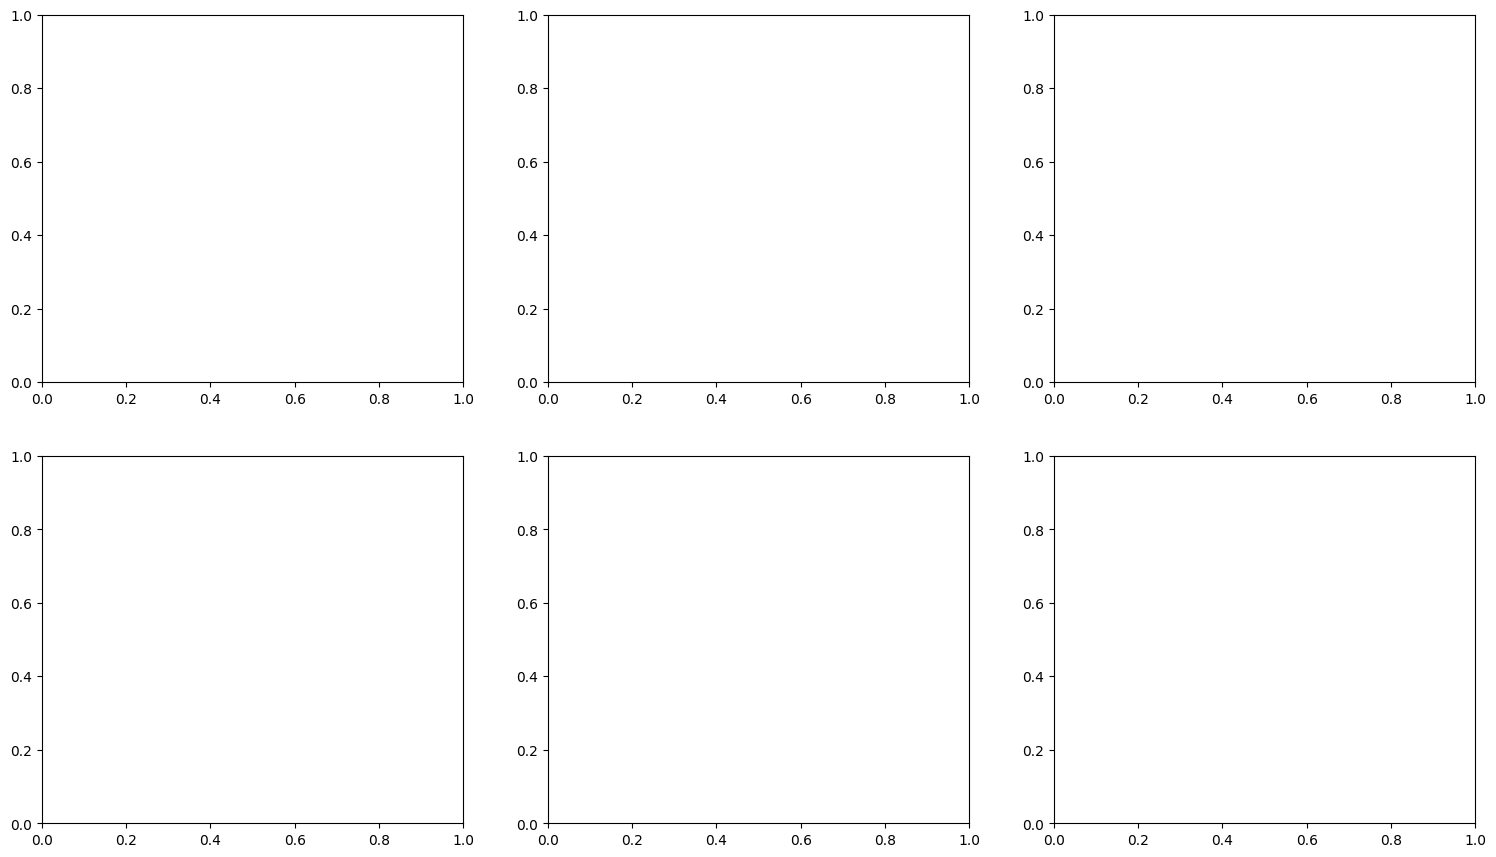

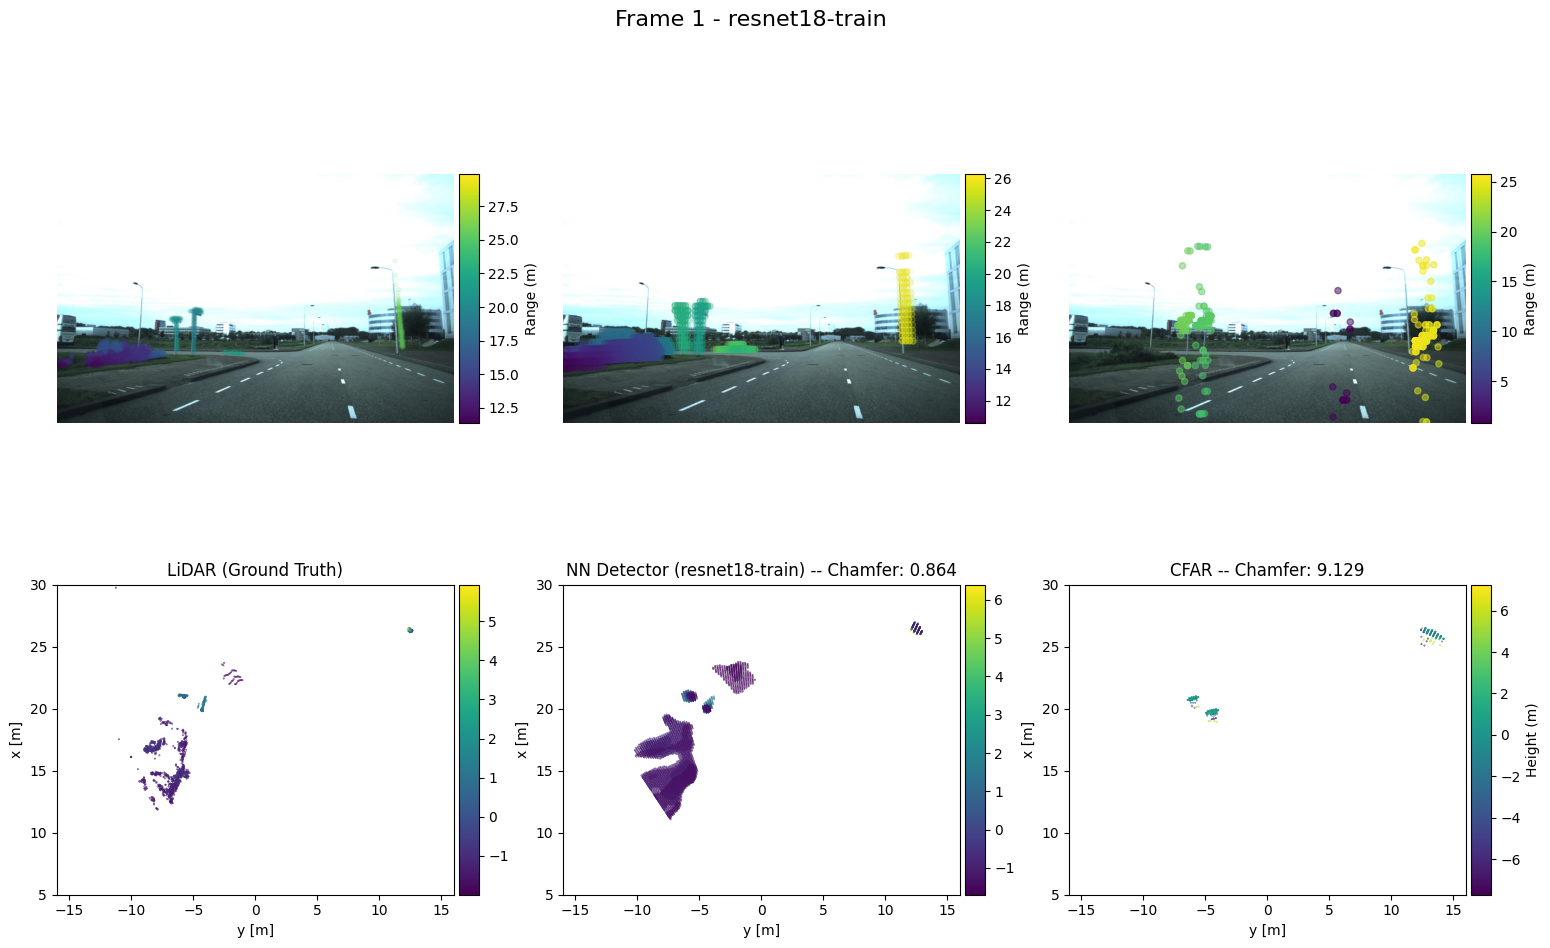

Video: resnet18-train: 21 frames [00:21,  1.01s/ frames]


Completed video for resnet18-train
Average Chamfer Distance - Radar: 0.855, CFAR: 9.019
Radar vs CFAR improvement: 90.5%
--------------------------------------------------
Creating video for resnet18-test...


Video: resnet18-test: 0 frames [00:00, ? frames/s]

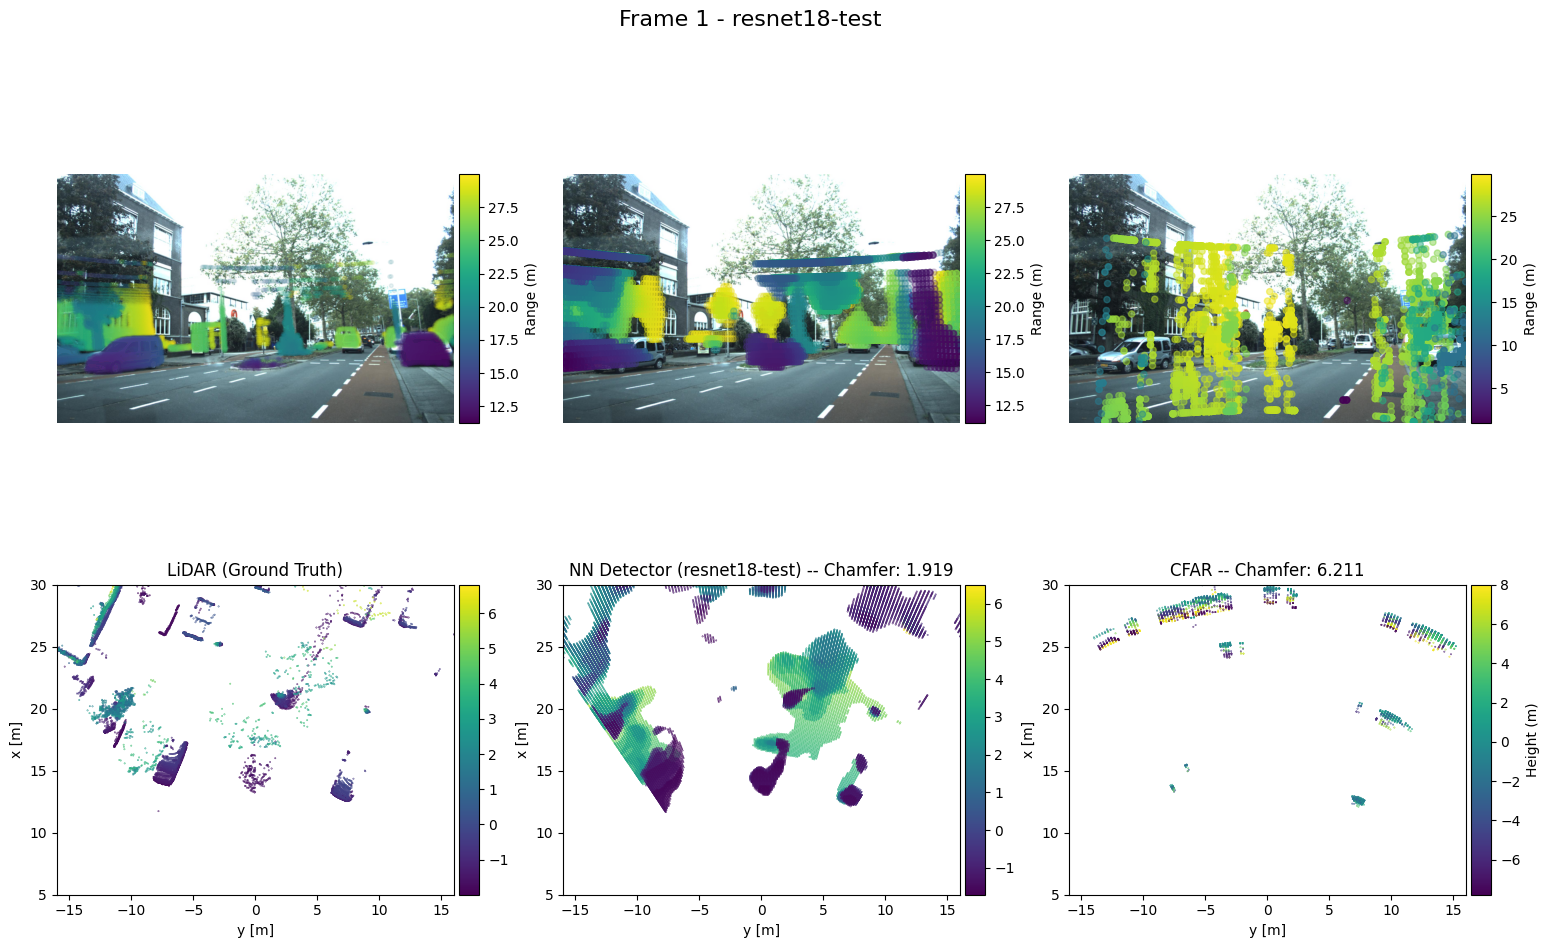

Video: resnet18-test: 21 frames [00:50,  2.42s/ frames]


Completed video for resnet18-test
Average Chamfer Distance - Radar: 1.578, CFAR: 6.430
Radar vs CFAR improvement: 75.5%
--------------------------------------------------
Creating video for resnet18-val...


Video: resnet18-val: 0 frames [00:00, ? frames/s]

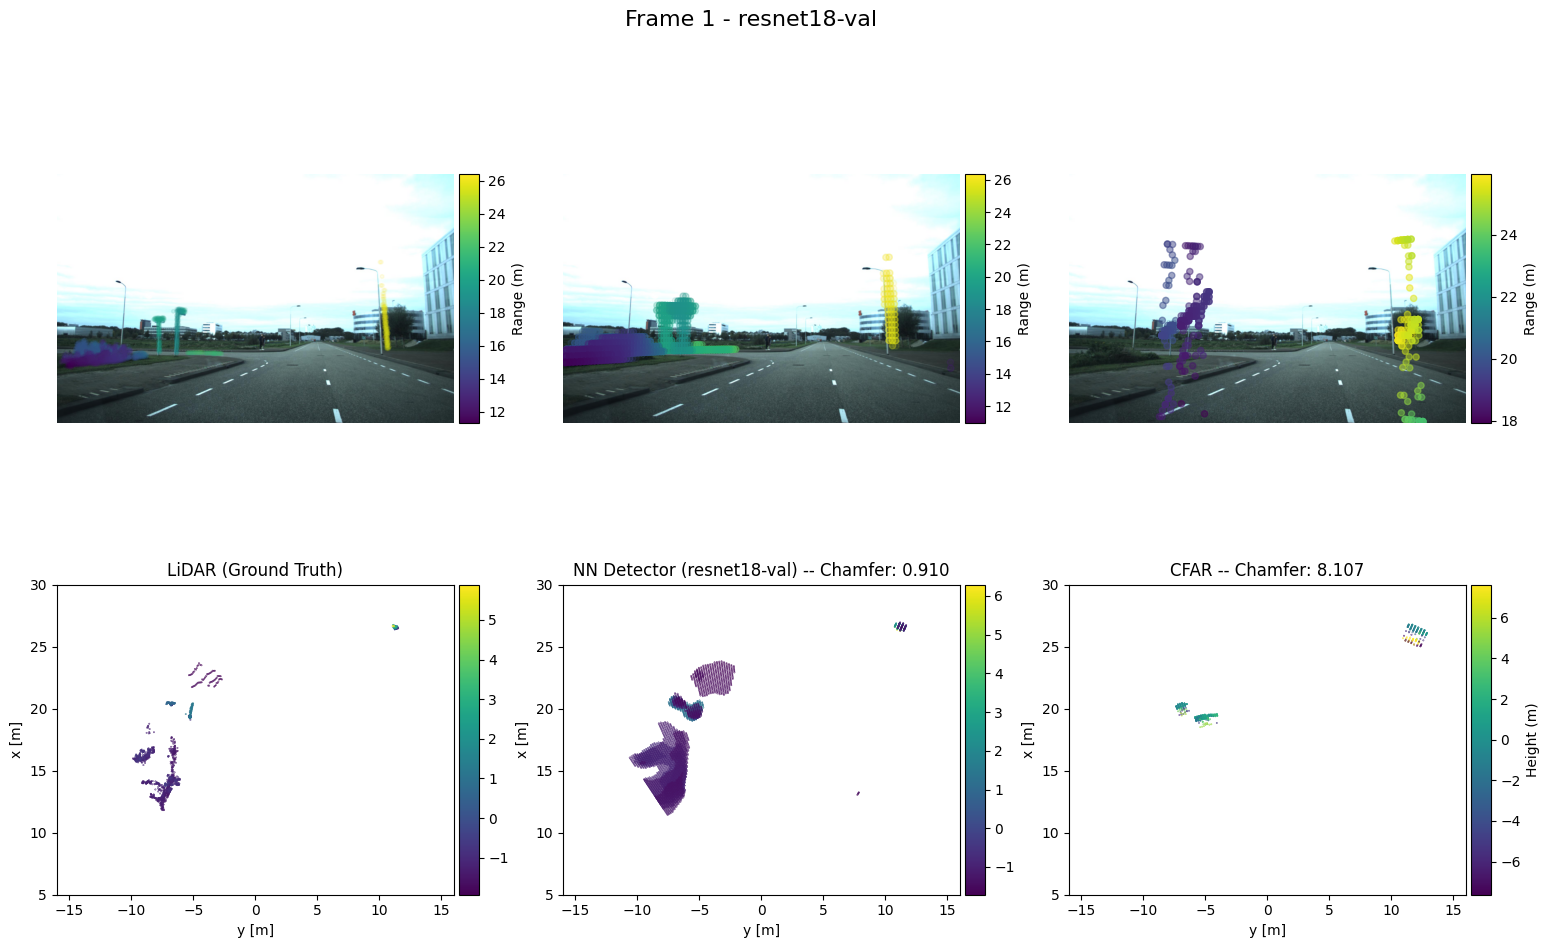

Video: resnet18-val: 21 frames [00:19,  1.08 frames/s]


Completed video for resnet18-val
Average Chamfer Distance - Radar: 0.836, CFAR: 7.581
Radar vs CFAR improvement: 89.0%
--------------------------------------------------
Creating video for resnet50-train...


Video: resnet50-train: 0 frames [00:00, ? frames/s]

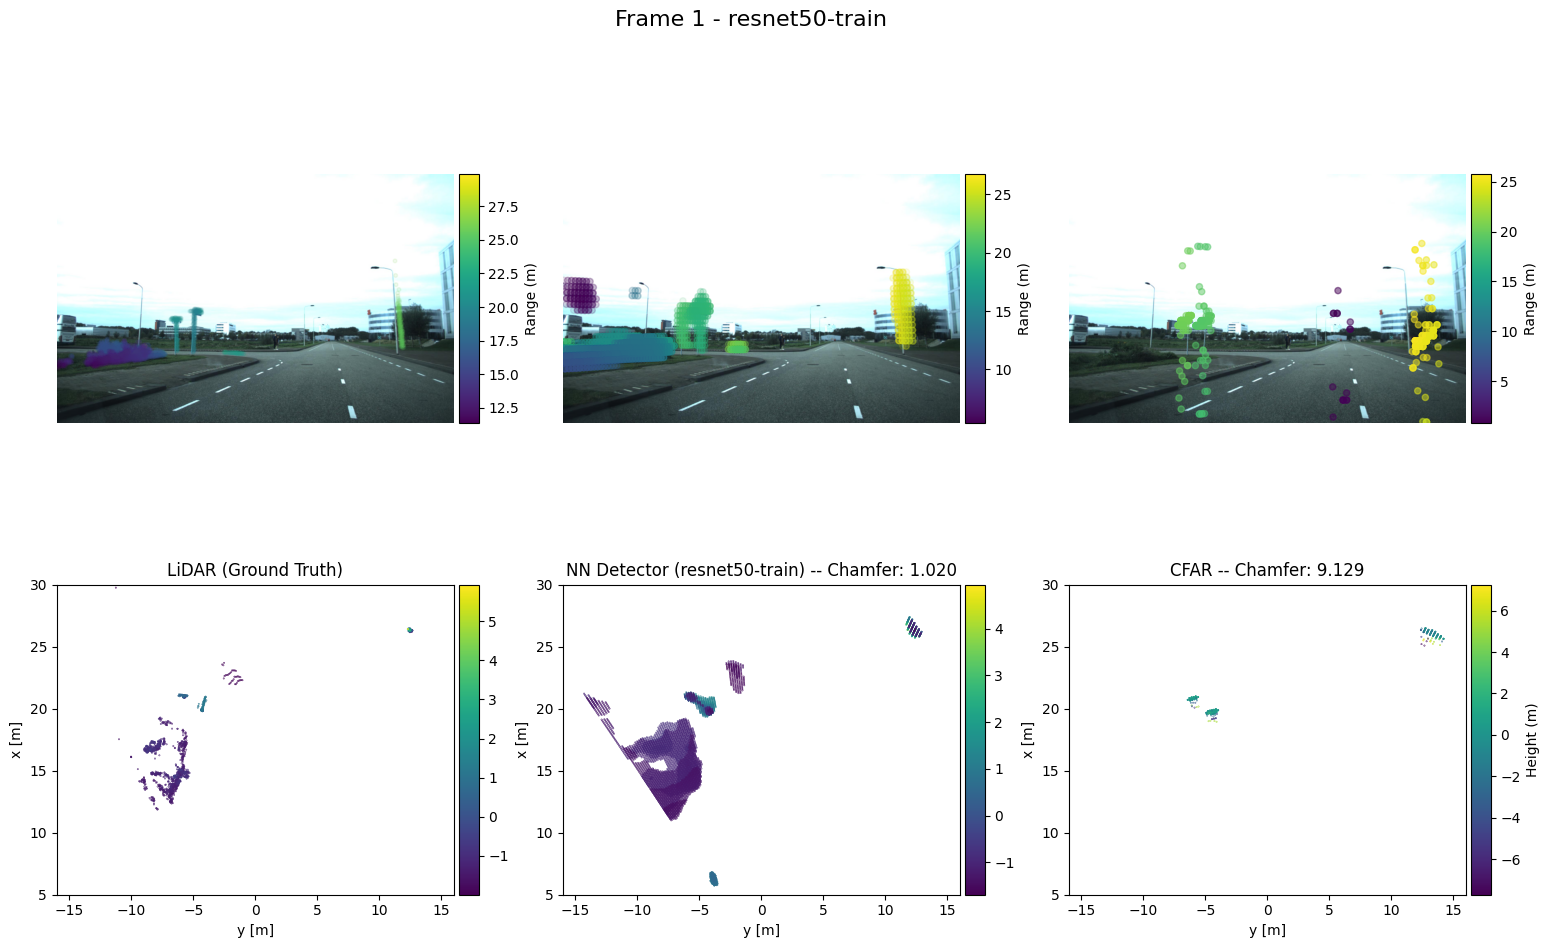

Video: resnet50-train: 21 frames [00:20,  1.00 frames/s]


Completed video for resnet50-train
Average Chamfer Distance - Radar: 0.998, CFAR: 9.019
Radar vs CFAR improvement: 88.9%
--------------------------------------------------
Creating video for resnet50-test...


Video: resnet50-test: 0 frames [00:00, ? frames/s]

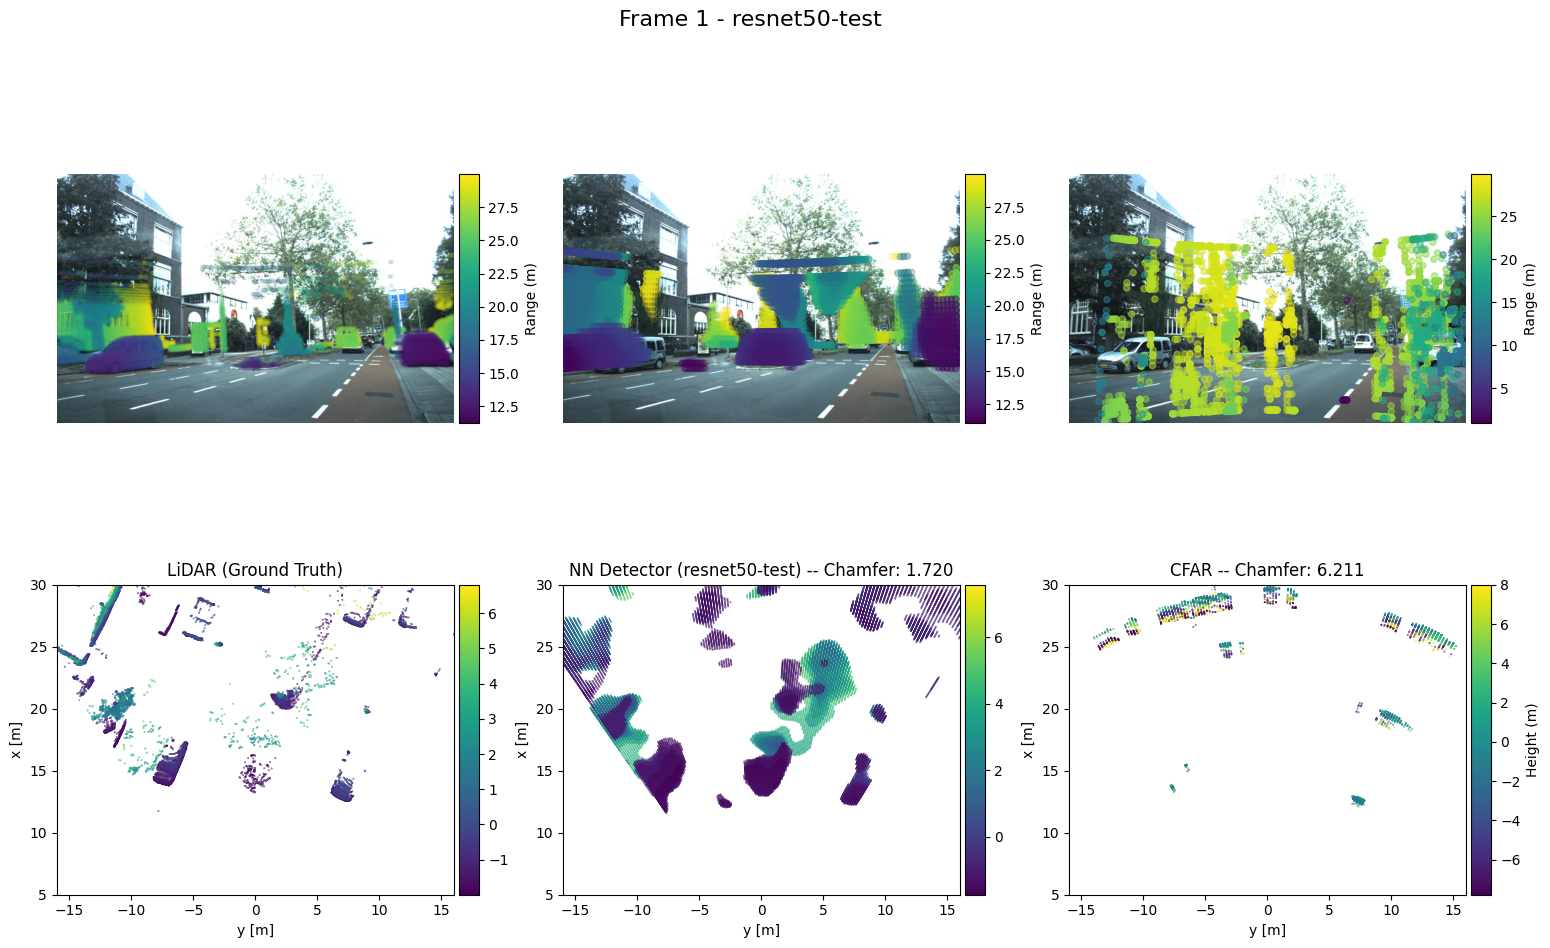

Video: resnet50-test: 21 frames [00:59,  2.81s/ frames]


Completed video for resnet50-test
Average Chamfer Distance - Radar: 1.510, CFAR: 6.430
Radar vs CFAR improvement: 76.5%
--------------------------------------------------
Creating video for resnet50-val...


Video: resnet50-val: 0 frames [00:00, ? frames/s]

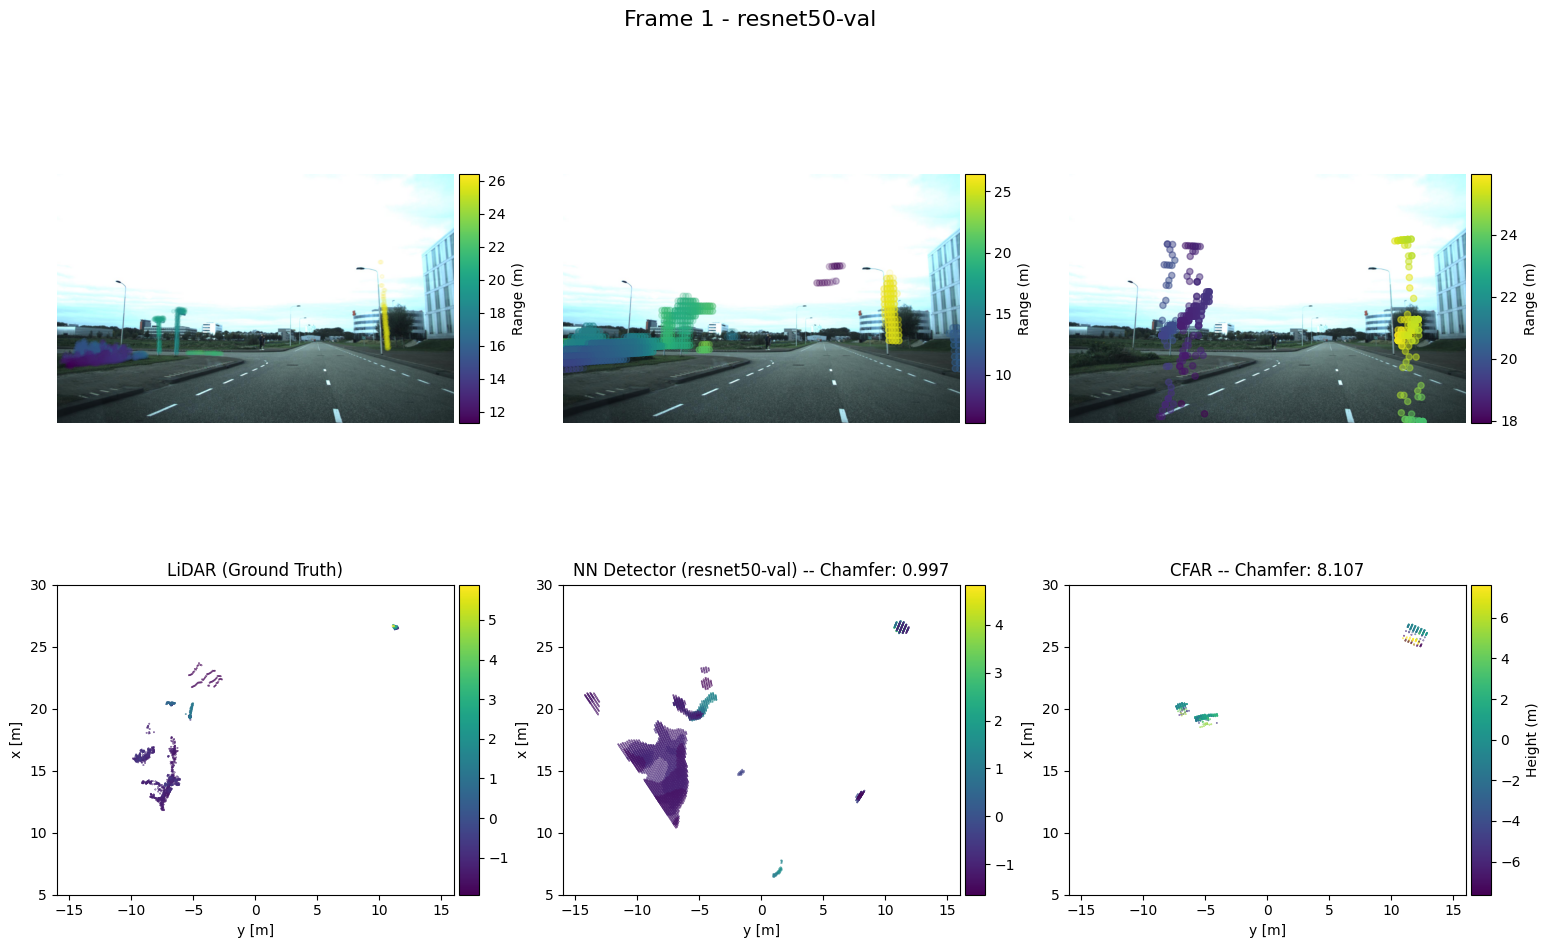

Video: resnet50-val: 21 frames [00:20,  1.02 frames/s]


Completed video for resnet50-val
Average Chamfer Distance - Radar: 0.911, CFAR: 7.581
Radar vs CFAR improvement: 88.0%
--------------------------------------------------


In [57]:
# Create 2x2 Figure for plots
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(18.5, 10.5)
max_frames = 25


# Chamfer distance function
def compute_chamfer_distance(point_cloud1, point_cloud2):
    """
    Compute the Chamfer distance between two set of points

    :param point_cloud1: the first set of points
    :param point_cloud2: the second set of points
    :return: the Chamfer distance
    """
    if len(point_cloud1) == 0 or len(point_cloud2) == 0:
        return float('inf')  # Return infinity if either point cloud is empty
        
    tree1 = KDTree(point_cloud1, metric='euclidean')
    tree2 = KDTree(point_cloud2, metric='euclidean')
    distances1, _ = tree1.query(point_cloud2)
    distances2, _ = tree2.query(point_cloud1)
    av_dist1 = np.sum(distances1) / np.size(distances1)
    av_dist2 = np.sum(distances2) / np.size(distances2)
    dist = av_dist1 + av_dist2

    return dist


# Create videos for all model-mode combinations with chamfer distance
def create_videos_for_all_models_with_chamfer(valid_data, max_frames=20):
    """
    Create separate videos for each model-mode combination with chamfer distance calculation
    """
    for model_mode_key, data_list in valid_data.items():
        if not data_list:
            print(f"Skipping {model_mode_key} - no data available")
            continue
            
        print(f"Creating video for {model_mode_key}...")
        
        # Store chamfer distances for analysis
        chamfer_distances_radar = []
        chamfer_distances_cfar = []
        
        fig, axs = plt.subplots(2, 3)
        fig.set_size_inches(18.5, 10.5)
        
        with Writer.saving(fig, f"./sensor_visualization_{model_mode_key}.mp4", 100):
            for counter, (cam, lidar, cfar, radar) in tqdm(enumerate(data_list), desc=f"Video: {model_mode_key}", unit=" frames"):
                if counter > max_frames:
                    break

                axs[0,0].cla()
                axs[0,1].cla()
                axs[1,0].cla()
                axs[1,1].cla()
                axs[0,2].cla()
                axs[1,2].cla()

                divider = make_axes_locatable(axs[0,0])
                cax00 = divider.append_axes("right", size="5%", pad=0.05)
                divider = make_axes_locatable(axs[0,1])
                cax01 = divider.append_axes("right", size="5%", pad=0.05)
                divider = make_axes_locatable(axs[1,0])
                cax10 = divider.append_axes("right", size="5%", pad=0.05)
                divider = make_axes_locatable(axs[1,1])
                cax11 = divider.append_axes("right", size="5%", pad=0.05)
                divider = make_axes_locatable(axs[0,2])
                cax02 = divider.append_axes("right", size="5%", pad=0.05)
                divider = make_axes_locatable(axs[1,2])
                cax12 = divider.append_axes("right", size="5%", pad=0.05)

                params = data_preparation.get_default_params()

                ####### Load and process LiDAR (ground truth) ######
                lidarpc = np.load(lidar)
                # lidarpc = rf.structured_to_unstructured(lidarpc)
                lidarpc = lidarpc.reshape(-1, 3)
                lidarpc = data_preparation.transform_point_cloud(
                    lidarpc,
                    [0, 0, -params['azimuth_offset']],
                    [-params['x_offset'] / 100, -params['y_offset'] / 100, 0]
                )
                lidarpc_bev = lidarpc

                
                # For chamfer distance, use 3D coordinates only
                lidarpc_3d = lidarpc[:, :3].copy()
                lidarpc_3d[:, 1] = -lidarpc_3d[:, 1]  # Apply coordinate transformation
                uvs_lidar, point_depths_lidar, filtered_idx_lidar = project_pcl_to_image(
                    lidarpc, transformation_matrix, camera_projection_matrix, (1216, 1936)
                )
                filter_by_distance_idx_lidar = filter_by_distance(point_depths_lidar, distance_from_camera)
                filtered_idx_lidar = np.logical_and(filtered_idx_lidar, filter_by_distance_idx_lidar)
                uvs_lidar = uvs_lidar[filtered_idx_lidar]

                # Get filtered LiDAR points for chamfer distance
                lidarpc_filtered = lidarpc_3d[filtered_idx_lidar]

                ####### Load and process Radar ######
                radar_points = np.load(radar)
                # Remove speed information if present (keep only x, y, z coordinates)
                if radar_points.shape[1] == 4:
                    radar_points = radar_points[:, :-1]  # Remove last column (speed)
                radarpc = radar_points.reshape(-1, 3)
                radarpc[:, 1] = -radarpc[:, 1]
                radarpc = data_preparation.transform_point_cloud(
                    radarpc,
                    [0, 0, -params['azimuth_offset']],
                    [-params['x_offset'] / 100, -params['y_offset'] / 100, 0]
                )
                radarpc_bev = radarpc
                uvs_radar, point_depths_radar, filtered_idx_radar = project_pcl_to_image(
                    radarpc, transformation_matrix, camera_projection_matrix, (1216, 1936)
                )
                filtered_by_distance_idx_radar = filter_by_distance(point_depths_radar, distance_from_camera)
                filtered_idx_radar = np.logical_and(filtered_idx_radar, filtered_by_distance_idx_radar)
                uvs_radar = uvs_radar[filtered_idx_radar]

                # Get filtered radar points for chamfer distance
                radarpc_filtered = radarpc[filtered_idx_radar]

                ####### Load and process CFAR ######
                cfar_points = data_preparation.read_pointcloud(cfar, mode="radar")
                # Ensure only 3D coordinates (x, y, z) are used for CFAR
                cfarpc = cfar_points[:, :3]  # Remove any additional columns beyond x, y, z
                cfarpc = data_preparation.transform_point_cloud(
                    cfarpc,
                    [0, 0, -params["azimuth_offset"]],
                    [-params["x_offset"] / 100, -params["y_offset"] / 100, 0]
                )
                cfarpc_bev = cfarpc
                uvs_cfar, point_depths_cfar, filtered_idx_cfar = project_pcl_to_image(
                    cfarpc, transformation_matrix, camera_projection_matrix, (1216, 1936)
                )
                filter_by_distance_idx_cfar = filter_by_distance(point_depths_cfar, distance_from_camera)
                filtered_idx_cfar = np.logical_and(filtered_idx_cfar, filter_by_distance_idx_cfar)
                uvs_cfar = uvs_cfar[filtered_idx_cfar]

                # Get filtered CFAR points for chamfer distance
                cfarpc_filtered = cfarpc[filtered_idx_cfar]

                ####### Calculate Chamfer Distances ######
                # print(f"Lidar PC: {lidarpc_bev}")
                # print(f"Radar PC: {radarpc_bev}")
                chamfer_radar = compute_chamfer_distance(lidarpc_bev, radarpc_bev)
                # print(chamfer_radar)
                chamfer_cfar = compute_chamfer_distance(lidarpc_bev, cfarpc_bev)
                
                chamfer_distances_radar.append(chamfer_radar)
                chamfer_distances_cfar.append(chamfer_cfar)

                ####### Plotting ######
                img = plt.imread(cam)

                # set titles with chamfer distances
                axs[1,0].set_title("LiDAR (Ground Truth)")
                axs[1,1].set_title(f"NN Detector ({model_mode_key}) -- Chamfer: {chamfer_radar:.3f}")
                axs[1,2].set_title(f"CFAR -- Chamfer: {chamfer_cfar:.3f}")
                fig.suptitle(f"Frame {counter + 1} - {model_mode_key}", fontsize=16)

                # Plot LiDAR
                cb00 = plot_points_on_image(axs[0,0], cax00, uvs_lidar, img, point_depths_lidar[filtered_idx_lidar], size=7, color_by="depth")
                cb10 = plot_bev(lidarpc[filtered_idx_lidar], axs[1,0], cax10, False)

                # Plot Radar
                cb01 = plot_points_on_image(
                    axs[0, 1], cax01, uvs_radar, img, point_depths=point_depths_radar[filtered_idx_radar], size=20, color_by='depth'
                )
                cb11 = plot_bev(radarpc[filtered_idx_radar], axs[1, 1], cax11, False)

                # Plot CFAR
                cb02 = plot_points_on_image(
                    axs[0, 2], cax02, uvs_cfar, img, point_depths=point_depths_cfar[filtered_idx_cfar], size=20, color_by='depth', alpha=0.5
                )
                cb12 = plot_bev(cfarpc[filtered_idx_cfar], axs[1, 2], cax12)

                # Update plot
                plt.pause(0.01)

                # Grab frame for video
                Writer.grab_frame()

                # clear plot
                cb00.remove()
                cb01.remove()
                cb10.remove()
                cb11.remove()
                cb02.remove()
                cb12.remove()
                
        plt.close(fig)
        
        # Print summary statistics
        avg_chamfer_radar = np.mean(chamfer_distances_radar)
        avg_chamfer_cfar = np.mean(chamfer_distances_cfar)
        
        print(f"Completed video for {model_mode_key}")
        print(f"Average Chamfer Distance - Radar: {avg_chamfer_radar:.3f}, CFAR: {avg_chamfer_cfar:.3f}")
        print(f"Radar vs CFAR improvement: {((avg_chamfer_cfar - avg_chamfer_radar) / avg_chamfer_cfar * 100):.1f}%")
        print("-" * 50)

# Run the video generation with chamfer distance calculation
create_videos_for_all_models_with_chamfer(valid_data, max_frames=20)

# Uncomment to create videos for all models:
# create_videos_for_all_models(valid_data, max_frames=20)
